<center>

# What's Cooking Challenge

### <i> Progetto per l'esame di Programmazione di applicazioni di Data Intensive (2019) </i>

### Cichetti Federico, Sponziello Nicolò
</center>

Il progetto ha lo scopo di creare un modello in grado di classificare il tipo di cucina di una ricetta in base agli ingredienti forniti.

## Librerie

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import pickle
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC

%matplotlib inline

nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Esplorazione dei dati

Partiamo caricando i dati in un dataframe Pandas e visualizzandone una parte per capire come sono strutturati

In [3]:
df = pd.read_json("train.json")
pd.options.display.max_colwidth = 500

In [4]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam masala, double cream, natural yogurt, bay leaf]"


In [5]:
df.tail()

,cuisine,id,ingredients
39769,irish,29109,"[light brown sugar, granulated sugar, butter, warm water, large eggs, all-purpose flour, whole wheat flour, cooking spray, boiling water, steel-cut oats, dry yeast, salt]"
39770,italian,11462,"[KRAFT Zesty Italian Dressing, purple onion, broccoli florets, rotini, pitted black olives, Kraft Grated Parmesan Cheese, red pepper]"
39771,irish,2238,"[eggs, citrus fruit, raisins, sourdough starter, flour, hot tea, sugar, ground nutmeg, salt, ground cinnamon, milk, butter]"
39772,chinese,41882,"[boneless chicken skinless thigh, minced garlic, steamed white rice, baking powder, corn starch, dark soy sauce, kosher salt, peanuts, flour, scallions, Chinese rice vinegar, vodka, fresh ginger, egg whites, broccoli, toasted sesame seeds, sugar, store bought low sodium chicken stock, baking soda, Shaoxing wine, oil]"
39773,mexican,2362,"[green chile, jalapeno chilies, onions, ground black pepper, salt, chopped cilantro fresh, green bell pepper, garlic, white sugar, roma tomatoes, celery, dried oregano]"


Il dataframe ha tre colonne:
- "cuisine" indica il tipo di cucina a cui appartiene il piatto. Questa sarà l'incognita da scoprire.
- "id" è una colonna che contiene un numero identificativo di ogni piatto. Questo dato non è utile al problema, quindi decidiamo di eliminare la colonna e usare come identificativo l'indice aggiunto in automatico da Pandas.
- "ingredients" contiene la lista di ingredienti del piatto.

In [6]:
if "id" in df:
    df.drop("id", inplace=True, axis=1)
df.head()

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam masala, double cream, natural yogurt, bay leaf]"


Prima di procedere si esplorano e visualizzano alcuni dati, in particolare:
* Quante ricette sono presenti
* La totalità degli ingredienti

In [7]:
len(df)

39774

Le ricette da classificare nel dataset sono 39774 in totale.

In [8]:
len(df['cuisine'].unique())

20

In totale ci sono 20 tipi di cucine differenti. Si tratta quindi di un problema di classificazione multiclasse.
Controlliamo quanti piatti ci sono per ogni cucina.

In [9]:
df['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

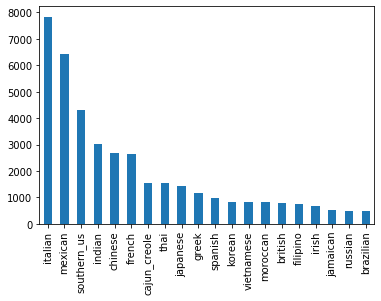

In [10]:
df['cuisine'].value_counts().plot("bar")

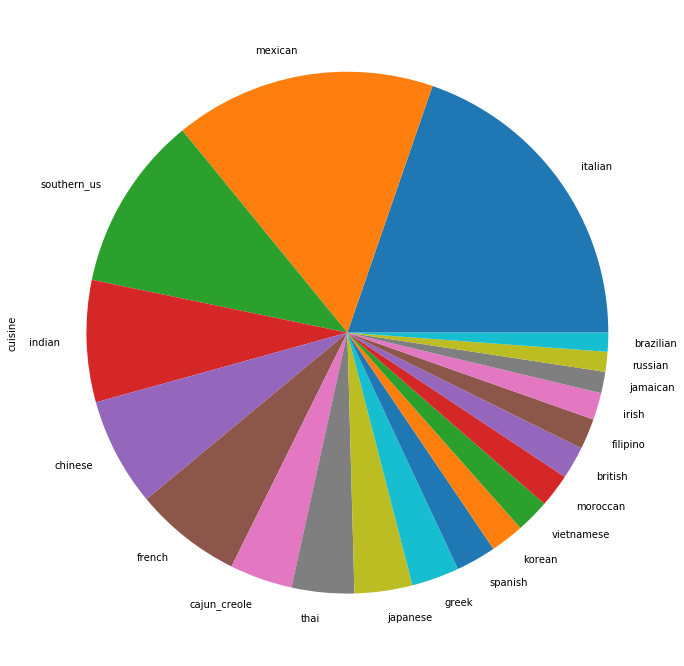

In [11]:
plt.figure(figsize=(12, 12))
df['cuisine'].value_counts().plot.pie()

Dal grafico possiamo notare che le classi sono sbilanciate, cioè sono presenti molte ricette che vengono identificate come cucina italiana e messicana, mentre ci sono poche ricette russe e brasiliane.

Per analizzare gli ingredienti, per adesso usiamo un approccio iterativo. Si crea un set di ingredienti in modo da eliminare eventuali duplicati.

In [12]:
ingredients = set()
for recipe in df['ingredients']:
    for i in recipe:
        ingredients.add(i)

In [13]:
len(ingredients)

6714

In totale notiamo che in tutto ci sono 6714 ingredienti diversi nel dataset.

Visualizziamo quelli più usati. Per fare questo gli ingredienti vanno inseriti in una lista in modo da mantenere i duplicati che poi dovranno essere contati.

In [14]:
ingredients_list = list()
for i in df['ingredients']:
    for word in i:
        ingredients_list.append(word)

In [15]:
common_ingredients = pd.Series(ingredients_list)
common_ingredients.value_counts().nlargest(15)

salt                   18049
olive oil               7972
onions                  7972
water                   7457
garlic                  7380
sugar                   6434
garlic cloves           6237
butter                  4848
ground black pepper     4785
all-purpose flour       4632
pepper                  4438
vegetable oil           4385
eggs                    3388
soy sauce               3296
kosher salt             3113
dtype: int64

Questi sono gli ingredienti più comuni

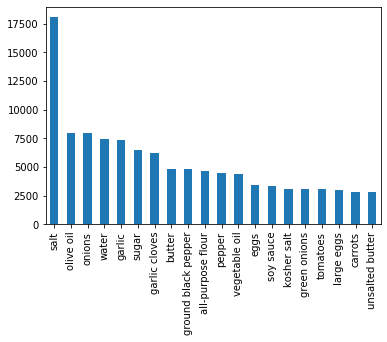

In [16]:
common_ingredients.value_counts().nlargest(20).plot(kind="bar")

Visualizziamo ora gli ingredienti più comuni per ogni cucina. Si crea un dizionario che contiene per ogni cucina un dizionario ingrediente -> numero di occorrenze e lo si ordina per tale conteggio. Possiamo poi costruire un DataFrame per visualizzare efficacemente quali sono gli ingredienti più usati.

In [17]:
tmp = df.groupby('cuisine')['ingredients'].apply(list)

def most_common_ingr_by_cuisine(cuisine):
    lists = tmp[cuisine]
    res = defaultdict(int)
    for recipe in lists:
        for ingr in recipe:
            res[ingr] += 1
    return sorted(res.items(), key=lambda x: x[1], reverse=True)

Chiamando la funzione qui sopra passando, ad esempio, la classe "italian" possiamo vedere che sale, olio di oliva, aglio e parmigiano sono alcuni degli ingredienti più comuni della cucina italiana.

In [18]:
commons_ital = pd.DataFrame(most_common_ingr_by_cuisine('italian'), columns=["ingredient", "count"]).head(10)
commons_ital

,ingredient,count
0,salt,3454
1,olive oil,3111
2,garlic cloves,1619
3,grated parmesan cheese,1580
4,garlic,1471
5,ground black pepper,1444
6,extra-virgin olive oil,1362
7,onions,1240
8,water,1052
9,butter,1030


In realtà il sale è l'ingrediente più comune per molte cucine.

In [19]:
pd.DataFrame(most_common_ingr_by_cuisine('french'), columns=["ingredient", "count"]).head(3)

,ingredient,count
0,salt,1203
1,sugar,637
2,all-purpose flour,593


In [20]:
pd.DataFrame(most_common_ingr_by_cuisine('brazilian'), columns=["ingredient", "count"]).head(3)

,ingredient,count
0,salt,194
1,onions,133
2,olive oil,118


Definiamo ora una funzione che restituisca il numero di ingredienti medio per ogni ricetta di una determinata cucina.

In [21]:
def avg_ingr_per_recipe(cuisine):
    recipes = tmp[cuisine]
    count = 0;
    for recipe in recipes:
        for ingr in recipe:
            count += 1;
    return count/len(recipes)

avg_ingr_per_recipe('brazilian')

9.5203426124197

In [22]:
average = {cuisine: avg_ingr_per_recipe(cuisine) for cuisine in df['cuisine'].unique()}
average

{'greek': 10.182127659574467,
 'southern_us': 9.634953703703705,
 'filipino': 10.0,
 'indian': 12.705960705960706,
 'jamaican': 12.214828897338403,
 'spanish': 10.42366026289181,
 'italian': 9.909032916560347,
 'mexican': 10.87744641192917,
 'chinese': 11.98279087167976,
 'british': 9.708955223880597,
 'thai': 12.545808966861598,
 'vietnamese': 12.675151515151516,
 'cajun_creole': 12.617076326002588,
 'brazilian': 9.5203426124197,
 'french': 9.817838246409675,
 'japanese': 9.735066760365426,
 'irish': 9.299850074962519,
 'korean': 11.28433734939759,
 'moroccan': 12.909866017052375,
 'russian': 10.224948875255624}

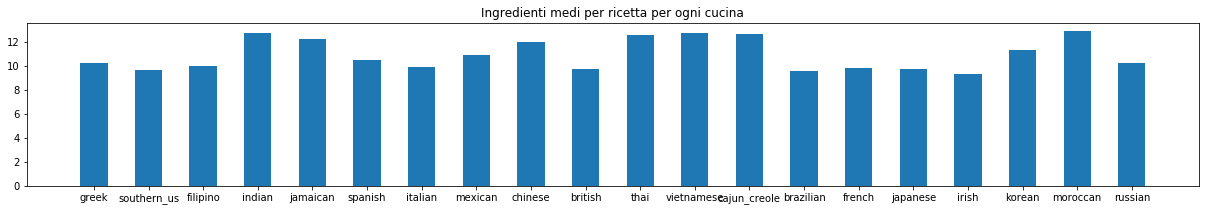

In [23]:
plt.figure(figsize=(21, 3))
plt.bar(average.keys(), average.values(), align="center", width=0.5)
plt.title("Ingredienti medi per ricetta per ogni cucina")
plt.show()

# Preprocessing dei dati

In questa fase, partendo dai risultati dell'analisi, effettuiamo una trasformazione dei dati in modo che siano pronti per essere elaborati dagli algoritmi di learning.

Come abbiamo potuto notare, il dataframe si compone di righe formate da:

- **[cuisine]**: categoria di cucina
- **[ingredients]**: lista di ingredienti in formato testuale

Una prima domanda che ci si può porre è come gestire gli ingredienti di una ricetta dato che spesso, come emerso dall'analisi dei dati, sono composti da più parole.
- Una soluzione possibile è quella di considerarli cosi come sono presenti, cioè "black olives" rimarrebbe "black olives"
- Oppure si potrebbero unire tutti gli ingredienti di una ricetta in un'unica stringa e applicare tecniche di text processing per cercare di estrarre più informazioni possibili
    - Stemming, Bag of Word, Vector Space Model

## Binarizzazione

Un primo approccio naive sarebbe quello di estrarre dal dataset un set contenente tutti gli ingredienti presenti e binarizzare ogni ricetta.
- Ad ogni riga, che rappresenta una ricetta, è associato un vettore di elementi in [0, 1] in cui la cella corrispondente all'ingrediente contiene 1 se è usato nella ricetta, 0 altrimenti.
- Avremmo ottenuto un dataset con circa 6700 features e 40'000 istanze, con un'alta occupazione di memoria e lunghi tempi di calcolo.

Oltre ad essere evidentemente un metodo poco scalabile, lento, e che occupa livelli veramente alti di memoria, lavora considerando troppi ingredienti e probabilmente è troppo complesso per essere efficace. In seguito ad alcuni test non riportati, si è effettivamente rivelato abbastanza inefficiente e inaccurato, motivo per cui sono stati subito scelti approcci differenti, previlegiando soluzioni con un numero di feature ridotto.

## Vector Space Model

Questo modello consente di rappresentare le ricette come vettori all'interno di un iperspazio in cui a ogni singola parola del dizionario comune (in questo caso, ogni singolo ingrediente) viene associato un peso che indica quanto esso contraddistingua la ricetta stessa.
Il modello tf-idf si adatta particolarmente bene allo scopo, in quanto:
- Associa ad ogni parola un peso che dipende sia dalla frequenza di uso locale Tf (cioè nella stessa ricetta) sia negli altri documenti idf (ricette)
- Tutti gli ingredienti vengono mappati
- I valori per ogni parola sono normalizzati in [0, 1]
- Le parole in comune vengono raggruppate: non ci sono duplicati


Di default, un TfidfVectorizer() effettua del preprocessing prima di creare la matrice che contiene i pesi. Questo preprocessing può comprendere l'eliminazione di eventuali stopword (cioè parole inglesi di poca importanza nella comprensione dei contenuti che vengono scartate), segni di punteggiatura e tanto altro. Una possibile variante è quella di considerare le ricette sia divise per singole parole che per n-uple.

Per prima cosa, manipoliamo la colonna 'ingredients' del dataframe
- trasformiamo la lista di ingredienti in un'unica stringa in modo che possa essere letta dal tokenizer

In [24]:
for idx in df.index:
    txt = ""
    for ing in df.loc[idx, "ingredients"]:
        txt += (ing + " ")
    df.loc[idx, "ingredients"] = txt

In [25]:
df.head()

,cuisine,ingredients
0,greek,romaine lettuce black olives grape tomatoes garlic pepper purple onion seasoning garbanzo beans feta cheese crumbles
1,southern_us,plain flour ground pepper salt tomatoes ground black pepper thyme eggs green tomatoes yellow corn meal milk vegetable oil
2,filipino,eggs pepper salt mayonaise cooking oil green chilies grilled chicken breasts garlic powder yellow onion soy sauce butter chicken livers
3,indian,water vegetable oil wheat salt
4,indian,black pepper shallots cornflour cayenne pepper onions garlic paste milk butter salt lemon juice water chili powder passata oil ground cumin boneless chicken skinless thigh garam masala double cream natural yogurt bay leaf


Creiamo i set per il training dei modelli e il calcolo dello score sul validation

In [26]:
X_t, X_v, y_t, y_v = train_test_split(df['ingredients'], df['cuisine'], random_state=42, test_size=1/3)

In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Nota per le seguenti GridSearch

In alcune GridSearch sono stati volontariamente omessi alcuni valori di iperparametri che sono stati testati individualmente su altri notebook. Questa decisione è stata fatta per alleggerire i tempi di calcolo di questo notebook in modo da presentare solo risultati rilevanti.

## Perceptron

Iniziamo lo studio dei modelli di classificazione partendo dal più semplice: il Perceptron. Con class_weight="balanced" si fa un tentativo di bilanciare le classi dato che come si è visto ci sono molte più ricette italiane e messicane che altre.

In [28]:
perceptron = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("perc", Perceptron())
])

Per ottimizzare i parametri, usiamo la Grid Search
 - Testiamo anche quale ngram ottimizza lo score

In [34]:
grid1 = {
    'tfidf__ngram_range':[(1, 1), (1, 2), (1, 3)],  #considerazioni di unigrammi, bigrammi, trigrammi
    'perc__penalty': ['l1', 'l2', None], #regolarizzazioni da effettuare
    'perc__alpha': np.logspace(-5, -3, 3), #peso della regolarizzazione
    'perc__class_weight': [None, "balanced"]
}
gs_perc = GridSearchCV(perceptron, param_grid=grid1, n_jobs=6)

In [35]:
gs_perc.fit(X_t, y_t)
gs_perc.score(X_v, y_v)

0.7459647005581536

In [36]:
pd.DataFrame(gs_perc.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_perc__alpha,param_perc__class_weight,param_perc__penalty,param_tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
43,3.641143,0.025497,0.978433,0.068148,0.001,None,None,"(1, 2)","{'perc__alpha': 0.001, 'perc__class_weight': None, 'perc__penalty': None, 'tfidf__ngram_range': (1, 2)}",0.731682,0.737557,0.734262,0.734500,0.002404,1
25,4.668360,0.111073,0.889224,0.009426,0.0001,None,None,"(1, 2)","{'perc__alpha': 0.0001, 'perc__class_weight': None, 'perc__penalty': None, 'tfidf__ngram_range': (1, 2)}",0.731682,0.737557,0.734262,0.734500,0.002404,1
7,3.622485,0.018397,0.936086,0.011998,1e-05,None,None,"(1, 2)","{'perc__alpha': 1e-05, 'perc__class_weight': None, 'perc__penalty': None, 'tfidf__ngram_range': (1, 2)}",0.731682,0.737557,0.734262,0.734500,0.002404,1
34,4.500367,0.031631,0.978558,0.017844,0.0001,balanced,None,"(1, 2)","{'perc__alpha': 0.0001, 'perc__class_weight': 'balanced', 'perc__penalty': None, 'tfidf__ngram_range': (1, 2)}",0.728403,0.739253,0.734715,0.734123,0.004450,4
52,3.840224,0.046549,0.945548,0.070940,0.001,balanced,None,"(1, 2)","{'perc__alpha': 0.001, 'perc__class_weight': 'balanced', 'perc__penalty': None, 'tfidf__ngram_range': (1, 2)}",0.728403,0.739253,0.734715,0.734123,0.004450,4


In [37]:
pd.Series(gs_perc.best_params_)

perc__alpha            1e-05
perc__class_weight      None
perc__penalty           None
tfidf__ngram_range    (1, 2)
dtype: object

Possiamo notare dall'analisi dei risultati prodotti dal Perceptron che le performance migliori si ottengono:
 - Nessun bilanciamento delle classi
 - Senza uso di penalizzazione
 - Considerando bigrammi

Si salva il modello su disco:

In [38]:
with open("what's_cooking_website/models/model_perc.bin", "wb") as f:
    pickle.dump(gs_perc.best_estimator_, f)

### Note riguardo al perceptron

Questo modello è già abbastanza buono, ma probabilmente si può fare di meglio. Il peso della regolarizzazione deve essere piuttosto piccolo e si preferisce una regolarizzazione di tipo L2.
Proviamo l'accuratezza di un modello casuale per vedere quanto si discosta da quella rilevata con il nostro modello.

In [39]:
cuisines = pd.Series(df["cuisine"].value_counts().keys(), index=range(0, 20, 1))
cuisines.head(5)

0        italian
1        mexican
2    southern_us
3         indian
4        chinese
dtype: object

In [40]:
random_predictions = [cuisines.iloc[random.randint(0, 19)] for i in range(0, len(X_v))]
print(str(len(random_predictions) == len(X_v)) + ", " + str(random_predictions[:5]))

True, ['moroccan', 'british', 'french', 'british', 'spanish']


In [41]:
ran_ser = pd.Series(random_predictions)
len(ran_ser[ran_ser == pd.Series(y_v.values)]) / len(X_v)

0.05091265650927742

L'accuratezza del circa 5% era attesa dato che si tratta di selezionare uno tra venti valori differenti.

## Miglioramento dei risultati (Regressione Logistica)

Proviamo a migliorare il risultato:
- Preprocessando in maniera differente i dati
- Utilizzando modelli più complessi e accurati

Definiamo una nostra funzione di preprocessing per avere più controllo su questa fase. Il processamento di un ingrediente viene fatto attraverso i seguenti passaggi:
- tokenizzazione per dividere in singole parole gli ingredienti multiparola
- casefolding
- rimozione delle stopwords e delle parole non-alfabetiche per sfoltire l'insieme degli ingredienti
- rimozione delle unità di misura
- stemming/lemmatization dei token ottenuti con i passaggi precedenti in modo da estrarre solamente la parte rilveante degli stessi (la loro radice morfologica)

In [42]:
units = ['oz', 'gram', 'g']

In [43]:
def preprocess_stem(ingredients):
    #tokenization
    tokens = nltk.tokenize.word_tokenize(ingredients)
    #token filtering
    tokens_left = {token.lower() for token in tokens} #casefolding
    for tok in set(tokens): #do not check duplicates
        if tok in nltk.corpus.stopwords.words("english") or not tok.isalpha() or tok in units: #non-alphabetic words and stopwords removal
            tokens_left.remove(tok)
    #stemming
    ps = nltk.stem.PorterStemmer()
    stemmed_tokens = {ps.stem(tok) for tok in tokens_left}
    return stemmed_tokens

Proviamo ora a testare questa funzione insieme a quella di default in una Grid Search in cui si utilizza come modello la Regressione Logistica. Mettiamo anche alcuni iperparametri della regressione nella Grid Search per ottenere il miglior modello possibile.

In [45]:
grid2 = {
    'model__C' : [1, 3, 5, 10],
    'tokenizer__tokenizer' : [None, preprocess_stem],
    'model__penalty': ['l2', 'l1']
}
logreg = Pipeline([
    ("tokenizer", TfidfVectorizer()),
    ("model",  LogisticRegression())
])
gs_logreg = GridSearchCV(logreg, param_grid=grid2, n_jobs=6)
gs_logreg.fit(X_t, y_t)
gs_logreg.score(X_v, y_v)

0.7869965303967416

In [46]:
pd.DataFrame(gs_logreg.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__penalty,param_tokenizer__tokenizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,8.879207,0.501214,0.500089,0.019472,5,l2,None,"{'model__C': 5, 'model__penalty': 'l2', 'tokenizer__tokenizer': None}",0.777250,0.779072,0.778193,0.778172,0.000744,1
9,244.661720,0.565447,113.159302,0.070128,5,l2,<function preprocess_stem at 0x000001835ECC5400>,"{'model__C': 5, 'model__penalty': 'l2', 'tokenizer__tokenizer': <function preprocess_stem at 0x000001835ECC5400>}",0.779059,0.775792,0.777966,0.777606,0.001358,2
4,8.477003,0.502657,0.487994,0.044570,3,l2,None,"{'model__C': 3, 'model__penalty': 'l2', 'tokenizer__tokenizer': None}",0.775328,0.778281,0.776721,0.776776,0.001206,3
5,243.664895,0.330717,120.420182,0.035630,3,l2,<function preprocess_stem at 0x000001835ECC5400>,"{'model__C': 3, 'model__penalty': 'l2', 'tokenizer__tokenizer': <function preprocess_stem at 0x000001835ECC5400>}",0.777929,0.775113,0.776155,0.776399,0.001162,4
13,237.116749,1.116657,123.217720,0.118301,10,l2,<function preprocess_stem at 0x000001835ECC5400>,"{'model__C': 10, 'model__penalty': 'l2', 'tokenizer__tokenizer': <function preprocess_stem at 0x000001835ECC5400>}",0.775441,0.775679,0.778080,0.776399,0.001192,4


In [49]:
pd.Series(gs_logreg.best_params_)

model__C                   5
model__penalty            l2
tokenizer__tokenizer    None
dtype: object

Notiamo dai risultati, che il modello migliore:
 - ha scelto C=5
 - regolarizzazione l2 
 - e come funzione di tokenizzazione del TfidfVectorizer la funzione di default

Nonostante il preprocessing potrebbe non essere ottimale, il modello è più accurato quindi possiamo cercare di capire che cosa ha imparato controllando i parametri.
Possiamo creare un DataFrame che associ a ogni cucina per tutte le parole del dizionario individuate dal Vectorizer il corrispondente peso.

In [50]:
model_logreg = gs_logreg.best_estimator_
coeffs = pd.DataFrame(model_logreg.named_steps["model"].coef_, index=model_logreg.classes_, columns=model_logreg.named_steps["tokenizer"].get_feature_names())
coeffs

,00,10,100,14,15,25,33,40,43,95,...,yuzu,yuzukosho,za,zatarainâ,zero,zest,zesty,zinfandel,ziti,zucchini
brazilian,-0.003428,-0.006816,-0.002762,-0.040508,-0.002517,-0.004436,-0.015792,-0.019640,2.529495,-0.001513,...,-0.018138,-0.003709,-0.017756,-0.018411,-0.000939,-0.247181,-0.085473,-0.139221,-0.293133,-1.331824
british,-0.072932,-0.008374,-0.071760,-0.061790,-0.005640,-0.010868,-0.027695,-0.008986,-0.039106,-0.004570,...,-0.046218,-0.020391,-0.000272,-0.001663,-0.004924,-0.908127,-0.079393,-0.209407,-0.068040,0.020903
cajun_creole,-0.006428,-0.008338,-0.003121,-0.090384,-0.009306,-0.014909,-0.591783,-0.093834,-0.058379,-0.027822,...,-0.062603,-0.011259,-0.002898,1.779929,-0.011184,-0.803346,0.404369,-0.153885,-0.167773,-1.097919
chinese,-0.032340,-0.006403,-0.020904,-0.014134,-0.014117,-0.039156,0.789376,-0.088628,-0.023378,-0.006314,...,-0.149553,-0.009087,-0.002210,-0.050034,-0.026200,-0.187691,-0.061937,-0.185668,-0.086212,-1.332952
filipino,-0.003584,-0.008911,-0.008327,-0.029839,-0.011737,-0.003177,-0.016756,-0.014067,-0.004506,-0.003405,...,-0.087493,-0.005603,-0.005141,-0.037122,-0.085903,-0.616137,-0.030187,-0.036404,-0.231335,-0.318920
french,-0.255221,-0.065110,-0.021021,-0.279663,-0.053512,-0.123094,-0.856193,-0.116626,-0.235308,-0.002139,...,-0.173197,-0.030808,-0.000383,-0.024221,-0.001984,0.230605,-0.355935,2.126759,-1.512926,3.535395
greek,-0.045341,0.383736,1.184221,-0.003730,-0.003346,-0.012250,-0.013558,-0.077276,-0.008483,-0.008438,...,-0.087491,-0.006191,-0.000032,-0.017690,-0.000738,-0.105102,1.401621,1.002731,1.008837,0.790994
indian,-0.029001,-0.021299,-0.027625,1.184558,-0.011478,-0.019023,-0.008947,-0.066081,-0.029924,-0.008803,...,-0.067559,-0.004989,-0.029331,-0.059958,-0.138603,0.271993,-0.047233,-0.060692,-0.068234,-0.358731
irish,-0.005528,-0.018792,-0.049788,-0.020100,-0.023104,-0.033038,-0.081431,-0.034902,-0.017705,-0.001088,...,-0.063094,-0.008970,-0.000270,-0.007021,-0.003073,1.393441,-0.204358,-0.301494,-0.112169,0.032458
italian,0.976774,-0.160584,-0.062983,0.098039,-0.112144,1.097433,0.496423,-0.175286,-0.328128,-0.031982,...,-0.274610,-0.087699,-0.000860,-0.126853,-0.020343,2.174196,-0.754025,-2.471613,2.088670,-0.583391


In questo modo selezionando una cucina e un ingrediente si può vedere il peso assegnato all'interno di una eventuale query.

In [51]:
coeffs.loc["italian", "mozzarella"]

5.407799875387056

In [52]:
coeffs.loc["mexican", "corn"]

3.7607077274217304

Possiamo inoltre studiare quali siano gli ingredienti più caratteristici di ogni cucina secondo questi pesi.

In [53]:
best_ing_data = {
    "cuisine" : df["cuisine"].unique(),
    "best_ingredient" : [coeffs.loc[cuisine, :].idxmax() for cuisine in df["cuisine"].unique()],
    "score" : [coeffs.loc[cuisine, :].max() for cuisine in df["cuisine"].unique()]
}
best_ingredients = pd.DataFrame(best_ing_data).set_index(["cuisine"])
best_ingredients

,best_ingredient,score
cuisine,,
greek,feta,12.497206
southern_us,grits,12.171223
filipino,calamansi,6.118243
indian,curry,10.159453
jamaican,jerk,11.986778
spanish,manchego,7.897172
italian,arborio,9.826289
mexican,tortillas,14.798581
chinese,szechwan,7.099470


Si nota già da questo DataFrame che gli ingredienti più caratteristici di alcune cucine sono semplicemente gli aggettivi che ne indicano le provenienze (irish, chinese che divente chines per la stemmatizzazione e in altre prove precedenti anche russian), nonostante non siano veri e propri ingredienti. Per le altre cucine, invece, gli ingredienti principali sono abbastanza realistici.

Proviamo ancora a migliorare i risultati utilizzando un modello ancora più complesso: SVM.

Ma prima, salviamo anche questo modello su disco. Dato che la funzione preprocess_stem non viene salvata all'interno del modello come ci aspettavamo, sul sito questo modello non sarebbe funzionante: perciò preferiamo salvare il secondo modello migliore che comunque è di poco meno preciso del primo.

In [54]:
logreg_2 = Pipeline([
    ("tokenizer", TfidfVectorizer(tokenizer=None)),
    ("model",  LogisticRegression(C=5, penalty='l2'))
])
logreg_2.fit(X_t, y_t)
logreg_2.score(X_v, y_v)

0.7869965303967416

In [55]:
with open("what's_cooking_website/models/model_logreg.bin", "wb") as f:
    pickle.dump(logreg_2, f)

## Support Vector Machines

Le Support Vector Machines sono uno strumento molto potente per individuare iperpiani di separazione ottimi, ovvero quelli che generano minore overfitting. Invece di considerare tutte le istanze, si considerano solo quelle vicine al decision boundary, i cosiddetti Support Vector e si cerca di massimizzare la distanza tra questi punti e l'iperpiano.

Gli iperparametri per SVM sono i seguenti:
- il tipo di funzione kernel da usare
- C, ovvero un parametro che controlla l'overfitting effettuando uno spostamento dei dati misclassified
- gamma, ovvero un parametro che controlla quanto il decision boundary sia flessibile (in rbf corrisponde all'ampiezza della gaussiana)

Abilitiamo anche probability=True per abilitare l'utilizzo di predict_proba nel modello finale.

In [56]:
grid3 = {
    'model__gamma' : [0.1, 1, 5],
    'model__C' : [1, 5],
    'model__kernel' : ['rbf', 'poly']
}
SVC = Pipeline([
    ("tokenizer", TfidfVectorizer()),
    ("model",  SVC(probability=True))
])
gs_SVC = GridSearchCV(SVC, grid3, n_jobs=6)

In [57]:
gs_SVC.fit(X_t, y_t)
gs_SVC.score(X_v, y_v)

0.8045708251621663

In [58]:
pd.DataFrame(gs_SVC.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__gamma,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,480.248019,1.229833,43.258370,1.026420,5,1,rbf,"{'model__C': 5, 'model__gamma': 1, 'model__kernel': 'rbf'}",0.792515,0.786878,0.788836,0.789410,0.002337,1
8,386.160786,0.350783,41.040465,0.158866,1,1,rbf,"{'model__C': 1, 'model__gamma': 1, 'model__kernel': 'rbf'}",0.781321,0.781109,0.778533,0.780321,0.001267,2
12,249.683995,0.567908,36.233769,0.318638,5,0.1,rbf,"{'model__C': 5, 'model__gamma': 0.1, 'model__kernel': 'rbf'}",0.774084,0.772851,0.770494,0.772477,0.001489,3
5,899.474259,1.403667,44.673116,0.089949,0.1,5,poly,"{'model__C': 0.1, 'model__gamma': 5, 'model__kernel': 'poly'}",0.747286,0.745475,0.740942,0.744569,0.002668,4
15,926.223316,1.225796,50.502734,0.266738,5,1,poly,"{'model__C': 5, 'model__gamma': 1, 'model__kernel': 'poly'}",0.747399,0.745249,0.740942,0.744532,0.002684,5


In [61]:
pd.Series(gs_SVC.best_params_)

model__C           5
model__gamma       1
model__kernel    rbf
dtype: object

Con un'accuratezza del 0.80457 il modello SVM è il più preciso fra quelli ottenuti.
 - C = 5
 - Gamma = 1
 - Kernel = RBF

Ancora una volta, salviamo il modello su disco:

In [62]:
with open("what's_cooking_website/models/model_SVM.bin", "wb") as f:
    pickle.dump(gs_SVC.best_estimator_, f)

## Affidabilità dei modelli

Si vuole calcolare quanto i modelli trovati finora siano affidabili. Per farlo utilizzeremo diverse metriche:
- Si calcola la matrice di confusione
- Si calcolano precision, recall e f1-score dei modelli
- Calcolo degli intervalli di confidenza con confidenza fissata al 95%

Carichiamo i modelli dalla memoria in modo da poter eseguire questa parte senza dover necessariamente eseguire le precedenti.

In [63]:
with open("what's_cooking_website/models/model_perc.bin", "rb") as f:
    model_perc_conf_test = pickle.load(f)

In [64]:
with open("what's_cooking_website/models/model_logreg.bin", "rb") as f:
    model_logreg_conf_test = pickle.load(f)

In [65]:
with open("what's_cooking_website/models/model_SVM.bin", "rb") as f:
    model_SVM_conf_test = pickle.load(f)

In [66]:
def confusion_matrix_calculation(model):
    return confusion_matrix(y_v, model.predict(X_v))

def calculate_precision_recall_f1(model):
    y_v_predictions = model.predict(X_v)
    p = precision_score(y_v, y_v_predictions, pos_label=1, average="macro")
    r = recall_score(y_v, y_v_predictions, average="macro")
    f1 = f1_score(y_v, y_v_predictions, average="macro")
    return {"precision" : p, "recall": r, "f1-score": f1}

In [67]:
#matrice di confusione del modello perceptron
conf_perc = pd.DataFrame(confusion_matrix_calculation(model_perc_conf_test), index=average.keys(), columns=average.keys())
conf_perc

,greek,southern_us,filipino,indian,jamaican,spanish,italian,mexican,chinese,british,thai,vietnamese,cajun_creole,brazilian,french,japanese,irish,korean,moroccan,russian
greek,91,2,4,3,6,3,1,3,3,7,4,1,1,17,0,2,9,4,3,1
southern_us,3,108,2,4,1,34,4,7,21,14,0,2,1,8,1,11,46,2,0,2
filipino,4,6,337,1,2,13,2,1,2,30,5,1,1,25,2,5,91,9,0,2
indian,0,2,3,677,13,7,0,4,4,10,3,47,19,7,1,2,11,1,21,15
jamaican,9,1,3,35,109,7,0,2,1,6,0,8,5,11,1,2,10,4,7,6
spanish,3,33,14,3,3,534,16,7,24,139,5,8,3,21,4,13,72,16,1,2
italian,0,1,0,0,0,14,265,8,2,56,0,1,1,3,7,2,8,15,0,2
mexican,5,5,5,4,3,7,10,876,0,5,5,12,3,16,25,3,7,5,12,0
chinese,1,20,0,2,0,33,5,1,99,13,1,0,1,4,1,3,36,5,1,0
british,13,15,14,4,4,109,55,16,8,2200,4,7,5,35,16,5,45,44,2,1


In [68]:
#matrice di confusione del modello di regressione logistica
conf_logreg = pd.DataFrame(confusion_matrix_calculation(model_logreg_conf_test), index=average.keys(), columns=average.keys())
conf_logreg

,greek,southern_us,filipino,indian,jamaican,spanish,italian,mexican,chinese,british,thai,vietnamese,cajun_creole,brazilian,french,japanese,irish,korean,moroccan,russian
greek,89,1,4,2,7,3,0,3,1,9,1,0,0,22,0,1,17,1,4,0
southern_us,0,130,2,0,0,37,1,4,15,21,0,1,0,2,0,8,49,1,0,0
filipino,1,3,354,4,0,15,1,0,2,31,0,1,0,16,1,7,96,6,0,1
indian,1,2,3,723,8,6,0,2,0,12,0,23,14,7,0,0,15,0,16,15
jamaican,5,0,0,35,132,8,0,5,1,7,0,3,3,9,0,0,13,2,2,2
spanish,1,15,8,3,3,572,5,2,14,186,4,1,0,11,0,12,73,11,0,0
italian,0,2,0,0,0,11,274,3,0,69,1,0,0,3,5,1,6,10,0,0
mexican,2,0,2,2,5,7,10,906,0,9,1,1,3,19,19,2,6,2,12,0
chinese,0,8,2,2,0,31,4,2,100,17,1,0,0,3,0,1,53,2,0,0
british,1,5,6,2,0,89,33,5,4,2363,1,3,0,14,6,3,47,20,0,0


In [69]:
#matrice di confusione del modello SVM
conf_SVC = pd.DataFrame(confusion_matrix_calculation(model_SVM_conf_test), index=average.keys(), columns=average.keys())
conf_SVC

,greek,southern_us,filipino,indian,jamaican,spanish,italian,mexican,chinese,british,thai,vietnamese,cajun_creole,brazilian,french,japanese,irish,korean,moroccan,russian
greek,97,0,4,1,3,2,0,4,1,11,0,0,0,22,0,1,15,1,3,0
southern_us,0,145,1,0,1,30,2,3,20,20,1,0,0,3,0,6,39,0,0,0
filipino,1,2,380,2,1,13,0,0,3,25,0,1,0,14,0,2,90,5,0,0
indian,1,1,1,740,8,5,0,3,0,10,0,20,9,7,0,0,11,1,18,12
jamaican,7,3,0,30,143,7,0,1,0,8,0,1,1,8,0,0,12,3,2,1
spanish,1,19,8,2,1,622,4,1,9,156,1,1,0,9,1,11,66,8,1,0
italian,0,0,0,0,0,12,278,3,0,71,0,0,0,3,4,0,4,10,0,0
mexican,0,1,0,3,4,6,9,911,0,8,2,2,1,15,19,1,10,2,13,1
chinese,0,16,1,1,0,30,4,1,117,15,0,0,0,3,0,2,36,0,0,0
british,0,4,5,1,0,100,33,4,1,2362,1,2,0,18,6,4,49,12,0,0


La matrice di confusione presenta sulla diagonale i valori predetti correttamente e nelle altre celle quelli che sono stati predetti in modo errato. 

Anche SVM, il modello migliore, fa abbastanza errori con alcune ricette (ad esempio scambia molti piatti britannici per piatti spagnoli. Questo errore è presente anche negli altri modelli: ne possiamo dedurre che molti ingredienti tra le due cucine siano in comune).

In [70]:
#calcolo delle statistiche per ogni modello trovato
pd.DataFrame([calculate_precision_recall_f1(model_perc_conf_test),
              calculate_precision_recall_f1(model_logreg_conf_test),
              calculate_precision_recall_f1(model_SVM_conf_test)],
                 index=["perceptron", "logreg", "SVM"])

,f1-score,precision,recall
perceptron,0.649583,0.661112,0.641279
logreg,0.709618,0.759640,0.674384
SVM,0.739529,0.785533,0.705676


Calcoliamo anche gli intervalli di confidenza dei modelli.

In [71]:
def confidence(acc, N, Z):
    den = (2*(N+Z**2))
    var = (Z*np.sqrt(Z**2+4*N*acc-4*N*acc**2)) / den
    a = (2*N*acc+Z**2) / den
    inf = a - var
    sup = a + var
    return (inf, sup)

def calculate_accuracy(conf_matrix):
    return np.diag(conf_matrix).sum() / conf_matrix.sum().sum()

In [72]:
#con confidenza del 0.95 si ha Z=1.96
pd.DataFrame([confidence(calculate_accuracy(conf_perc), len(X_v), 1.96),
              confidence(calculate_accuracy(conf_logreg), len(X_v), 1.96),
              confidence(calculate_accuracy(conf_SVC), len(X_v), 1.96)],
                 index=["perceptron", "logreg", "SVM"], columns=["inf", "sup"])

,inf,sup
perceptron,0.738484,0.753303
logreg,0.779944,0.793882
SVM,0.797733,0.811232


Dagli intervalli di confidenza al 95% abbiamo la conferma che SVM è il più accurato

## Bilanciamento delle classi

Proviamo ora a trasformare i dati in modo che le classi siano bilanciate per vedere se i risultati che si ottengono sono migliori o peggiori. Per farlo usiamo SMOTE che fa parte del modulo imblearn che deve essere scaricato con pip con il comando 
```python
pip3 install imblearn
```

In [73]:
from imblearn.over_sampling import SMOTE
balancer = SMOTE(random_state=42)
t = TfidfVectorizer()
balanced_matrix = t.fit_transform(df["ingredients"])
y_cpy = df["cuisine"]

In [74]:
X, y = balancer.fit_resample(balanced_matrix, y_cpy)

In [75]:
pd.Series(y).value_counts()

filipino        7838
jamaican        7838
russian         7838
indian          7838
brazilian       7838
chinese         7838
korean          7838
irish           7838
spanish         7838
mexican         7838
french          7838
vietnamese      7838
italian         7838
moroccan        7838
japanese        7838
thai            7838
british         7838
greek           7838
cajun_creole    7838
southern_us     7838
dtype: int64

Le classi sono state bilanciate.

In [109]:
model_balanced = LogisticRegression(C=5)
X_t_b, X_v_b, y_t_b, y_v_b = train_test_split(balanced_matrix, y_cpy, random_state=42, test_size=1/3)

In [107]:
model_balanced.fit(X_t_b, y_t_b)
model_balanced.score(X_v_b, y_v_b)

0.7869211042389501

Nonostante i dati siano ora bilanciati tramite oversampling, il modello non migliora la sua accuratezza. Tuttavia, un modello bilanciato dovrebbe essere meno soggetto a overfitting.

## Conclusioni

Su kaggle, dove la competition era stata proposta per la prima volta, grazie al modello SVM abbiamo ottenuto un punteggio uguale ai competitor nelle posizioni 233-235 su 1388 teams. Con il modello di regressione logistica ci eravamo piazzati circa a metà (circa 620esimi). Si potrebbero migliorare ancora di più questi risultati utilizzando altri modelli e lavorando ulteriormente sugli iperparametri nelle Grid Search, ma per ora ci sembra un ottimo risultato.